In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [296]:
train_csv = 'train_spam.csv'

train = pd.read_csv(train_csv)

print(len(train))
train.dropna(how='any')
print(len(train))

a = []
max = 0
for i in range(len(train)):
    a.append(train.iloc[i]['text'].split())
    if len(a[i]) > max:
        max = len(a[i])
print(max)

16278
16278


206

In [297]:
X_train0 = train['text']
y_train0 = train['text_type']

dict_y = {'spam' : 1,
          'ham' : 0}

y_dict = {1:'spam',
          0:'ham'}

y_train0_num = np.zeros_like(y_train0)
for i in range(len(y_train0)):
    y_train0_num[i] = dict_y[y_train0[i]]


In [273]:
X_train, X_test, y_train, y_test = train_test_split(X_train0, y_train0)

In [274]:
vectorizer = TfidfVectorizer(max_features=1000)

lin_model = LogisticRegression()
ens_model = RandomForestClassifier()

lin_params = {'lin_model__penalty' : ['l1', 'l2', 'elasticnet'],
              'lin_model__C' : [0.1, 1, 2, 5, 10, 100],
              'lin_model__max_iter': [10**i for i in range(2,4)]}

ens_params = {'ens_model__n_estimators': [10**2],
              'ens_model__criterion': ['gini'],
              }

lin_pipe = Pipeline([('vectorize', vectorizer), ('lin_model', lin_model)])
ens_pipe = Pipeline([('vectorize', vectorizer), ('ens_model', ens_model)])

lin_grid = GridSearchCV(lin_pipe, param_grid=lin_params)
ens_grid = GridSearchCV(ens_pipe, param_grid=ens_params)

In [275]:
lin_grid.fit(X_train, y_train)

c:\Users\Владимир\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Владимир\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

GridSearchCV(estimator=Pipeline(steps=[('vectorize',
                                        TfidfVectorizer(max_features=1000)),
                                       ('lin_model', LogisticRegression())]),
             param_grid={'lin_model__C': [0.1, 1, 2, 5, 10, 100],
                         'lin_model__max_iter': [100, 1000],
                         'lin_model__penalty': ['l1', 'l2', 'elasticnet']})

In [276]:
ens_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vectorize',
                                        TfidfVectorizer(max_features=1000)),
                                       ('ens_model',
                                        RandomForestClassifier())]),
             param_grid={'ens_model__criterion': ['gini'],
                         'ens_model__n_estimators': [100]})

In [277]:
print(f' best score for logistic regression = {lin_grid.best_estimator_.score(X_test, y_test)},for random forest =  {ens_grid.best_estimator_.score(X_test, y_test)}' )

 best score for logistic regression = 0.9127764127764127,for random forest =  0.9233415233415233


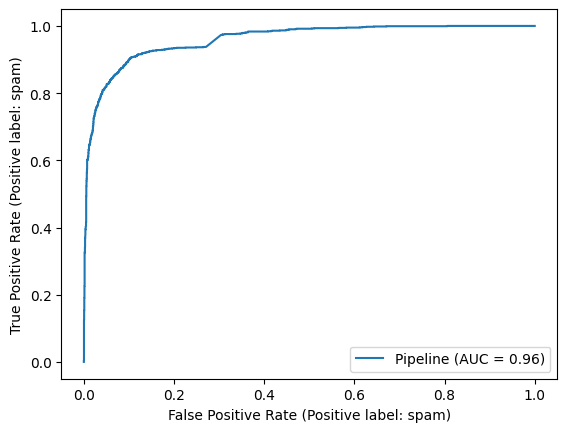

In [288]:
RocCurveDisplay.from_estimator(lin_grid.best_estimator_, X_test, y_test)
plt.show()

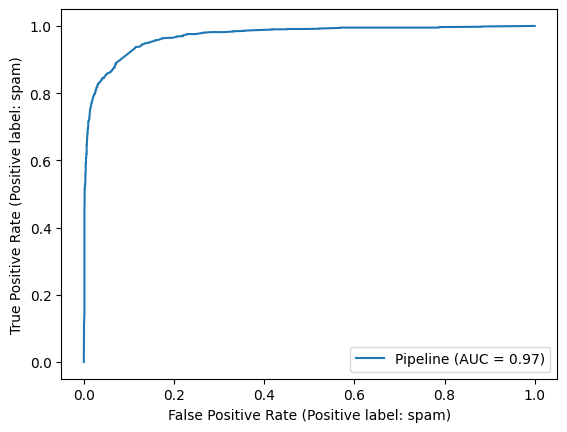

In [289]:
RocCurveDisplay.from_estimator(ens_grid.best_estimator_, X_test, y_test)
plt.show()

In [300]:
train_csv = 'train_spam.csv'

train = pd.read_csv(train_csv)

X_train0 = train['text']
y_train0 = train['text_type']

In [301]:
class CustomDataset(Dataset):
    def __init__(self, X, y):

        self.X = torch.tensor(X.todense(), dtype = torch.float32)
        self.y = torch.tensor(y)
    
    def __len__(self):
        
        return len(self.y)

    def __getitem__(self, idx):

        return self.X[idx], self.y[idx]

In [302]:
X = vectorizer.fit_transform(X_train0)



for i,j in enumerate(y_train0):
    y_train0[i] = dict_y[y_train0[i]]
        

dataset = CustomDataset(X, y_train0)

p = 0.8

train_size = int(p * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

In [303]:
dt_train = DataLoader(train_data, batch_size=32)
dt_test = DataLoader(test_data, batch_size=32)

for batch in dt_train:
    print(batch[0].shape, batch[1].shape)
    break

torch.Size([32, 1000]) torch.Size([32])


In [345]:
class RNN_for_classification(nn.Module):
    def __init__(self, inp_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(inp_size, hidden_size=20, num_layers=2, dropout=0.1)
        self.fc = nn.Linear(20, num_classes)  
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)  
        x = self.fc(x)
        x = self.sig(x)
        
        return x


In [346]:
rnn_model = RNN_for_classification(inp_size = 1000, num_classes = 2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

rnn_model.to(device)

RNN_for_classification(
  (lstm): LSTM(1000, 20, num_layers=2, dropout=0.1)
  (fc): Linear(in_features=20, out_features=2, bias=True)
  (sig): Sigmoid()
)

In [347]:
def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in (range(num_epochs)):
        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)
            

            # model forward-pass
            preds = model(X.float())
            

            # model backward-pass
            optimizer.zero_grad()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()

        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            with torch.no_grad():
                # model forward-pass
                preds = model(X.float())
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy
        print(f'номер эпохи {i_epoch}, test loss = {test_loss}')

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

In [348]:
criterion = nn.CrossEntropyLoss()

optimize = torch.optim.AdamW(rnn_model.parameters(), lr=0.0005)

In [349]:
train_losses, \
    test_losses, \
    train_accuracy_arr, \
    test_accuracy_arr = train(model = rnn_model, criterion=criterion,
                              optimizer=optimize,
                              train_dataloader=dt_train,
                              test_dataloader=dt_test,
                              num_epochs=25)

номер эпохи 0, test loss = 0.607454933664378
номер эпохи 1, test loss = 0.6033570515174492
номер эпохи 2, test loss = 0.5028304492726046
номер эпохи 3, test loss = 0.42743151415796843
номер эпохи 4, test loss = 0.4126891368160061
номер эпохи 5, test loss = 0.40586909827064066
номер эпохи 6, test loss = 0.40098219554798276
номер эпохи 7, test loss = 0.39824168150331457
номер эпохи 8, test loss = 0.39536705174866843
номер эпохи 9, test loss = 0.39432648846916124
номер эпохи 10, test loss = 0.3927837291768953
номер эпохи 11, test loss = 0.393465260664622
номер эпохи 12, test loss = 0.3930901385405484
номер эпохи 13, test loss = 0.39250708590535555
номер эпохи 14, test loss = 0.39250752125300614
номер эпохи 15, test loss = 0.3928024596443363
номер эпохи 16, test loss = 0.3934924339546877
номер эпохи 17, test loss = 0.39347709832238215
номер эпохи 18, test loss = 0.3938545605131224
номер эпохи 19, test loss = 0.3936612749216603
номер эпохи 20, test loss = 0.39343879912413804
номер эпохи 21,

In [350]:
model_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)
print(len(dataset))

16278


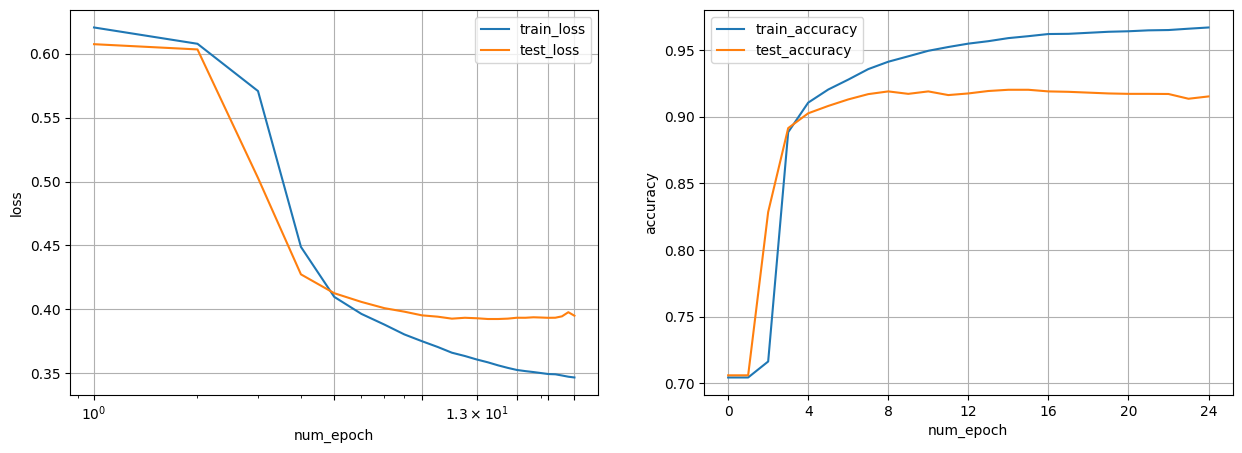

In [351]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].semilogx(np.arange(1, train_losses.shape[0] + 1), train_losses, label='train_loss')
ax[0].semilogx(np.arange(1, test_losses.shape[0] + 1), test_losses, label='test_loss')
ax[0].set_xticks(np.arange(1, train_losses.shape[0] + 1, 4))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(train_accuracy_arr.shape[0]), train_accuracy_arr,
           label='train_accuracy')
ax[1].plot(np.arange(test_accuracy_arr.shape[0]), test_accuracy_arr,
           label='test_accuracy')
ax[1].set_xticks(np.arange(0, train_accuracy_arr.shape[0], 4))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()

plt.savefig('huina.png')
plt.show()

In [358]:
preds = rnn_model(batch[0].to(device)).detach().cpu().numpy()

print(preds.argmax(-1) == batch[1].cpu().numpy())



[ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [384]:
test = 'test_spam.csv'
test_text = pd.read_csv(test)

print(test_text.iloc[0])
test_type = []
for i in range(len(test_text)):
    test_type.append(ens_grid.best_estimator_.predict(test_text.iloc[i]))
test_text.insert(0, 'score', test_type)
test_text.to_csv('score.csv', index = False)

text    j jim whitehead ejw cse ucsc edu writes j you ...
Name: 0, dtype: object
